In [1]:
from __future__ import division

import numpy as np
from scipy.signal import convolve2d
from sklearn import svm
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import pickle

%matplotlib inline

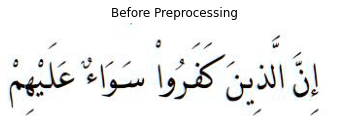

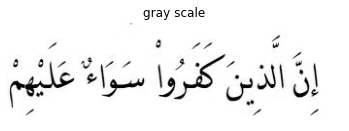

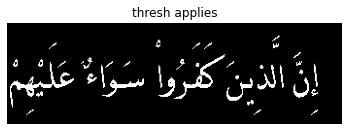

In [2]:
def prePro(img):
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    return thresh

image = cv2.imread('ACdata_base/2/0191.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

plt.imshow(image)
plt.axis("off")
plt.title("Before Preprocessing")
plt.show()

plt.imshow(gray , cmap="gray")
plt.axis("off")
plt.title("gray scale")
plt.show()

plt.imshow(thresh ,cmap="gray")
plt.axis("off")
plt.title("thresh applies")
plt.show()


In [3]:
#Parts of this code is taken from online sources but we fully understand it
def lpq(img,winSize=3,freqestim=1,mode='nh'):
    rho=0.90

    STFTalpha=1/winSize  # alpha in STFT approaches (for Gaussian derivative alpha=1)
    sigmaS=(winSize-1)/4 # Sigma for STFT Gaussian window (applied if freqestim==2)
    sigmaA=8/(winSize-1) # Sigma for Gaussian derivative quadrature filters (applied if freqestim==3)

    convmode='valid' # Compute descriptor responses only on part that have full neigborhood. Use 'same' if all pixels are included (extrapolates np.image with zeros).

    img=np.float64(img) # Convert np.image to double
    r=(winSize-1)/2 # Get radius from window size
    x=np.arange(-r,r+1)[np.newaxis] # Form spatial coordinates in window

    if freqestim==1:  #  STFT uniform window
        #  Basic STFT filters
        w0=np.ones_like(x)
        w1=np.exp(-2*np.pi*x*STFTalpha*1j)
        w2=np.conj(w1)

    ## Run filters to compute the frequency response in the four points. Store np.real and np.imaginary parts separately
    # Run first filter
    filterResp1=convolve2d(convolve2d(img,w0.T,convmode),w1,convmode)
    filterResp2=convolve2d(convolve2d(img,w1.T,convmode),w0,convmode)
    filterResp3=convolve2d(convolve2d(img,w1.T,convmode),w1,convmode)
    filterResp4=convolve2d(convolve2d(img,w1.T,convmode),w2,convmode)

    # Initilize frequency domain matrix for four frequency coordinates (np.real and np.imaginary parts for each frequency).
    freqResp=np.dstack([filterResp1.real, filterResp1.imag,
                        filterResp2.real, filterResp2.imag,
                        filterResp3.real, filterResp3.imag,
                        filterResp4.real, filterResp4.imag])

    ## Perform quantization and compute LPQ codewords
    inds = np.arange(freqResp.shape[2])[np.newaxis,np.newaxis,:]
    LPQdesc=((freqResp>0)*(2**inds)).sum(2)

    ## Switch format to uint8 if LPQ code np.image is required as output
    if mode=='im':
        LPQdesc=np.uint8(LPQdesc)

    ## Histogram if needed
    if mode=='nh' or mode=='h':
        LPQdesc=np.histogram(LPQdesc.flatten(),range(256))[0]

    ## Normalize histogram if needed
    if mode=='nh':
        LPQdesc=LPQdesc/LPQdesc.sum()

    return LPQdesc

In [4]:
#PreProcessing of image
import os
rawImage = []
truth=[]
for i in range(9):
    directory ='ACdata_base/'+str(i+1)+'/'
    for filename in os.listdir(directory):
        image = prePro(directory+filename)
        rawImage.append(image)
        truth.append(i+1)
feature_extraction = lpq(image)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(rawImage, truth, test_size=0.2, random_state=1)

In [6]:
## call lpq on each preprocessed image in the preprocessed training set Feauture extraction

X_train_FE =[]
for i in range(len(X_train)):
    image_FE = lpq(X_train[i])
    X_train_FE.append(image_FE)
        
     

     

In [7]:
## call lpq on each preprocessed image in the preprocessed training set

X_test_FE =[]
for i in range(len(X_test)):
    image_FE = lpq(X_test[i])
    X_test_FE.append(image_FE)
        
     

     

In [8]:
## svm implementation
## support vectors=training data set
## call it on the lpq x_train

X_FE =[]
for i in range(len(rawImage)):
    image_FE = lpq(rawImage[i])
    X_FE.append(image_FE)
        
     

In [9]:
## svm implementation

#Create a svm Classifier
#Used cross validation to get better parameters
clf = svm.SVC( C = 400 , gamma = 200 )

#Train the model using the training sets
clf.fit(X_train_FE, y_train)

#Predict the response for test dataset
y_predict = clf.predict( X_test_FE )
y_predict_train = clf.predict( X_train_FE )

# Model Accuracy: how often is the classifier correct?
print("Accuracy on Test:",metrics.accuracy_score(y_test, y_predict))
print("Accuracy on Train:",metrics.accuracy_score(y_train, y_predict_train))


Accuracy on Test: 0.9643916913946587
Accuracy on Train: 0.9992581602373887


In [10]:
#K folds 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
accuracy = cross_val_score(clf, X_FE,truth, scoring='accuracy', cv = folds)
print(np.mean(accuracy))

0.968545994065282


In [11]:
#satisfied with this accuracy then train the model again on all the data
clf.fit(X_FE,truth)

SVC(C=400, gamma=200)

In [12]:
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))
 

 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))